# 3. Simulation: Imbalanced Friedman1
Description: 
* Using friedman1-dataset from sklearn.datasets: imbalanced by cutting of 'y' > 17 with 70% of the data
* Taking samples from the dataset with preserving the proportions of the classes in both splits (training, test and validation) by stratification and comparing it to random splitting
* visual inspection of distribution of train-test split
* fit RandomForestRegressor
* RandomizedSearchCV for hyperparameter tuning
* Stratification based on quantiles with pd.qcut

In [1]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
from utils_Nadja import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf, fold_visualizer

## Dataset

In [3]:
features, y = generate_friedman1()
(features, y)

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        ...,
        [0.44278322, 0.57820664, 0.46877158, 0.14188158, 0.74118443],
        [0.53303816, 0.39932288, 0.5596385 , 0.24122695, 0.42795772],
        [0.6224452 , 0.22619357, 0.74899508, 0.52101091, 0.86170671]]),
 array([16.83826156, 12.51782504,  5.86968919, ..., 12.34777254,
        10.8228707 , 15.03893816]))

In [8]:
generated_data =to_dataframe(features=features, y=y)
generated_data

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.838262
1,0.155995,0.058084,0.866176,0.601115,0.708073,12.517825
2,0.020584,0.969910,0.832443,0.212339,0.181825,5.869689
3,0.183405,0.304242,0.524756,0.431945,0.291229,7.531879
4,0.611853,0.139494,0.292145,0.366362,0.456070,9.457372
...,...,...,...,...,...,...
9995,0.532481,0.550056,0.984144,0.599966,0.666627,21.977669
9996,0.213723,0.106865,0.602010,0.864880,0.587373,12.510693
9997,0.442783,0.578207,0.468772,0.141882,0.741184,12.347773
9998,0.533038,0.399323,0.559639,0.241227,0.427958,10.822871


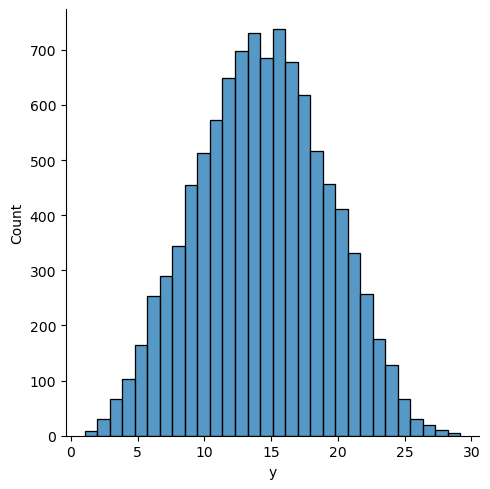

In [9]:
sns.displot(generated_data, x='y', bins = 30)

proportion of original data set 0.7
number of observaions 6983


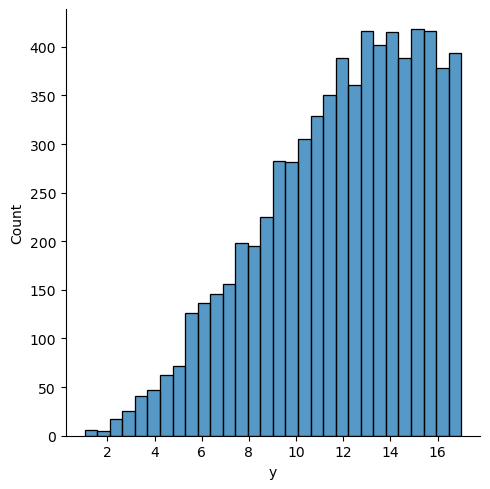

In [11]:
# make y distirbution imbalanced by deleting rows where ['y'] > 17 -> also makes data set smaller
df=generated_data.drop(generated_data[generated_data['y'] > 17].index)
#drop index
df=df.reset_index(drop=True)
sns.displot(df, x='y', bins = 30)

# proportion 
print("proportion of original data set", round(df.shape[0]/generated_data.shape[0], 2))
print("number of observaions", df.shape[0])

In [12]:
#plot_data_3D(df, ['X3', 'X4','X5'])

## Random Forest without stratificaation

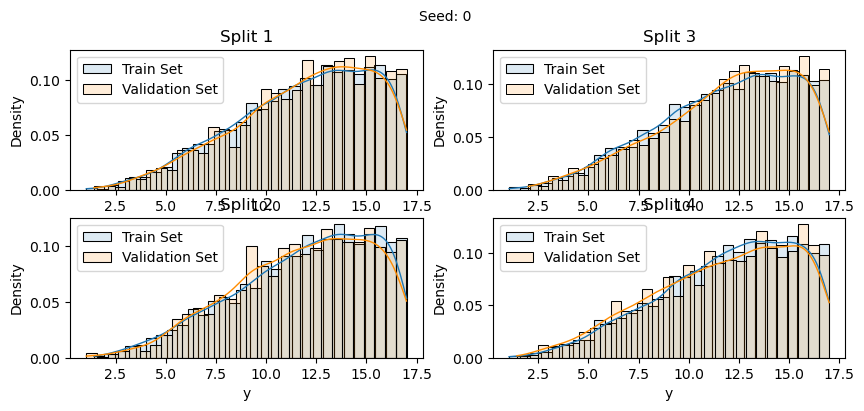

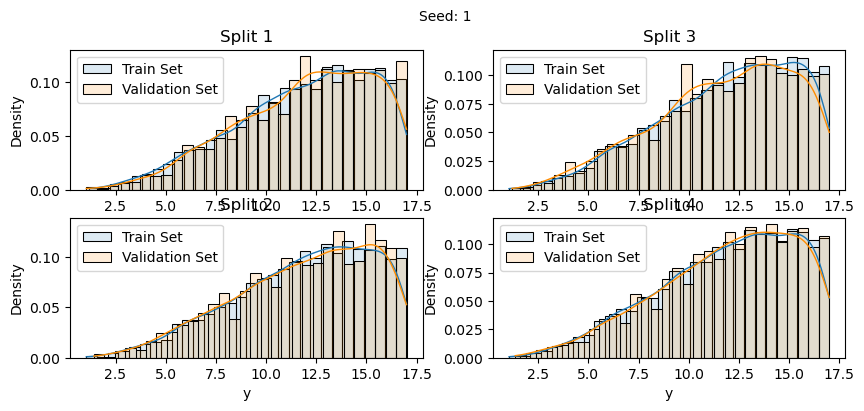

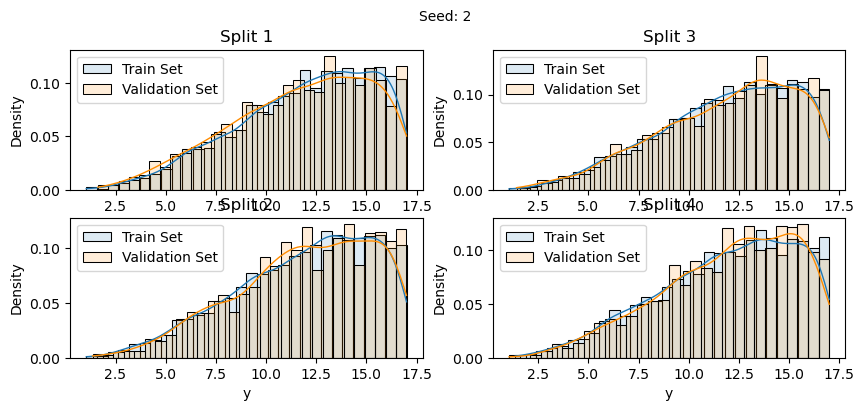

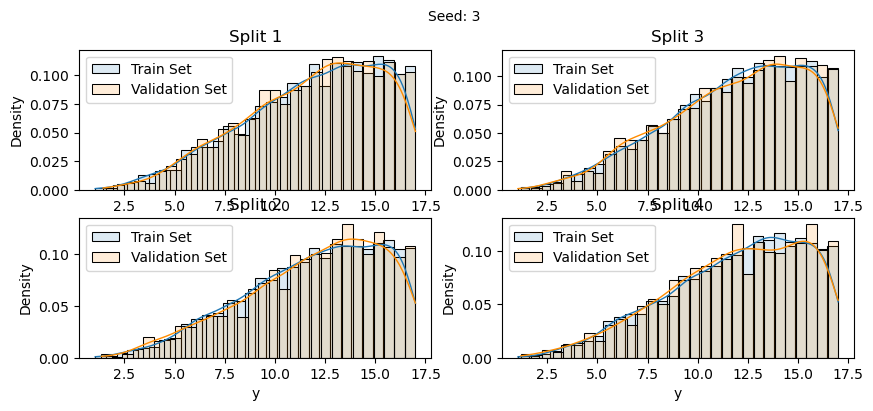

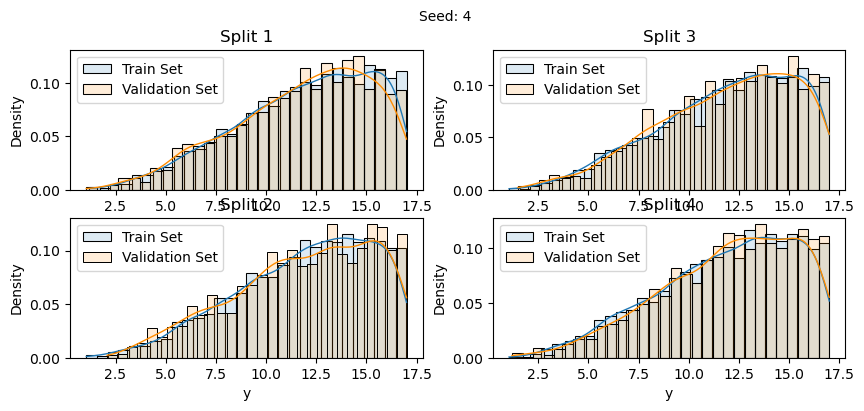

In [15]:
from sklearn.model_selection import KFold
labels = df['y']


for i in range(5):
    baseline_kfold = list(KFold(4,
                                shuffle=True,
                                random_state=i
                               ).split(labels))
    fold_visualizer(data=labels,
                    fold_idxs=baseline_kfold,
                    seed_num=i)

In [16]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[: , :-1], df['y'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5586, 5) (1397, 5) (5586,) (1397,)


In [19]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_rf,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

In [21]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)

# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [22]:
# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
train_score=best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f"Train Set R^2 Score: {train_score:.4f} \nTest Set R^2 Score: {test_score:.4f}")

Train Set R^2 Score: 0.9417 
Test Set R^2 Score: 0.8958


## Random Forest with stratifications

In [23]:
from sklearn.model_selection import StratifiedKFold

In [24]:
def create_cont_folds(df, n_s=4, n_grp=10, seed=1):
    # StratifiedKFold for classification
    skf = StratifiedKFold(n_splits=n_s, shuffle=True, random_state=seed)
    # q/n_grp = Number of quantiles
    grp = pd.qcut(x = df, q = n_grp, labels=False)
    target = grp
    
    fold_nums = np.zeros(len(df))
    for fold_no, (t, v) in enumerate(skf.split(target, target)):
        fold_nums[v] = fold_no
    
    cv_splits = []

    for i in range(num_of_folds):
        test_indices = np.argwhere(fold_nums==i).flatten()
        train_indices = list(set(range(len(labels))) - set(test_indices))
        cv_splits.append((train_indices, test_indices))
        
    return cv_splits

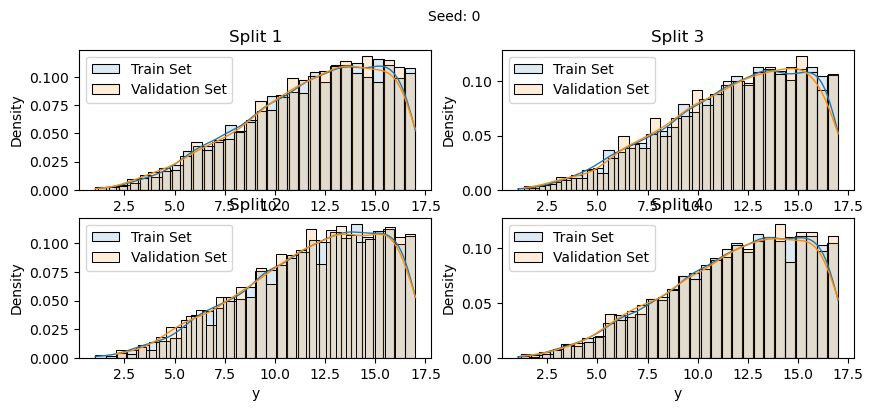

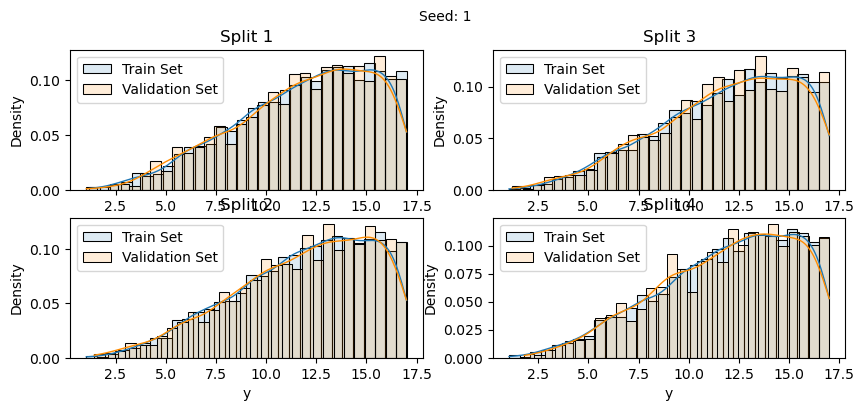

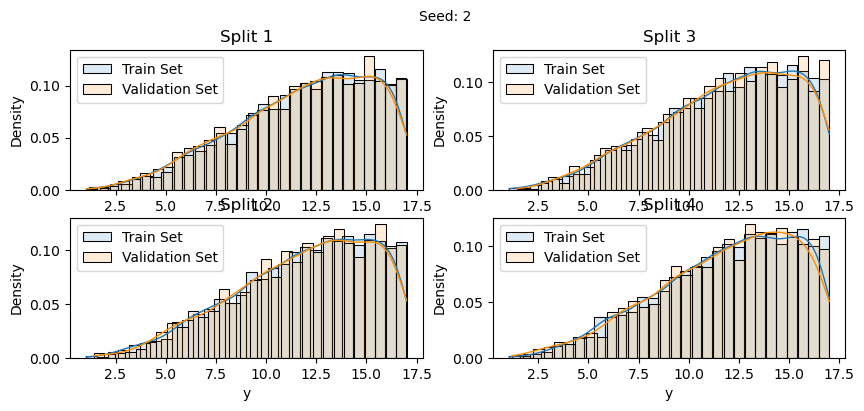

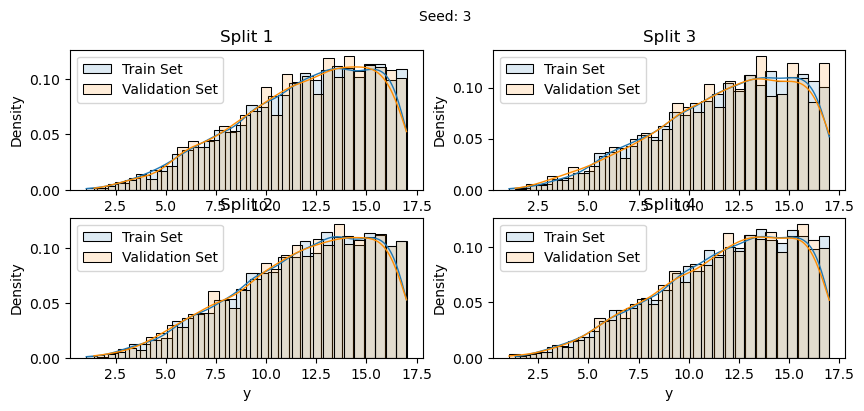

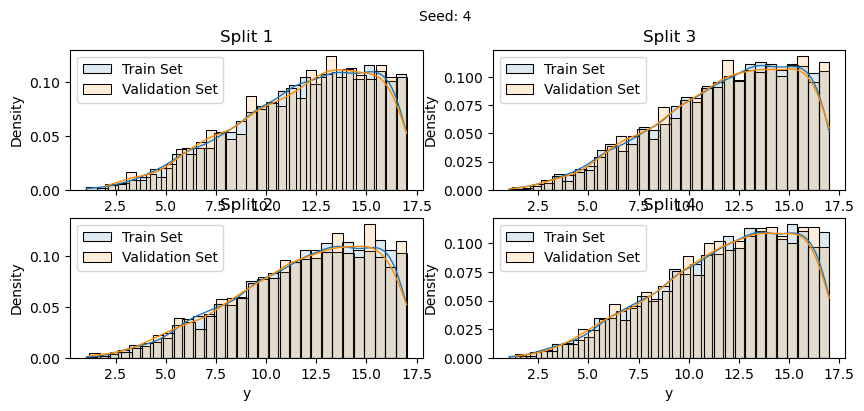

In [25]:
num_of_folds = 4
num_of_groups = 10

for i in range(5):
    cv_splits = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)
    fold_visualizer(data=labels,
                    fold_idxs=cv_splits,
                    seed_num=i)

In [26]:
X_train_stratified = df.loc[cv_splits[0][0], df.columns != 'y']
y_train_stratified = df.loc[cv_splits[0][0], 'y']

X_test_stratified = df.loc[cv_splits[0][1], df.columns != 'y']
y_test_stratified = df.loc[cv_splits[0][1], 'y']

# Verify the sizes of the train and test sets
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (5586, 5) (5586,)
Test set size: (1397, 5) (1397,)


In [27]:
X_train_stratified

,X1,X2,X3,X4,X5
0,0.374540,0.950714,0.731994,0.598658,0.156019
1,0.155995,0.058084,0.866176,0.601115,0.708073
2,0.020584,0.969910,0.832443,0.212339,0.181825
4,0.611853,0.139494,0.292145,0.366362,0.456070
5,0.785176,0.199674,0.514234,0.592415,0.046450
...,...,...,...,...,...
6974,0.037028,0.443589,0.247206,0.396525,0.986083
6976,0.572161,0.226109,0.718364,0.680274,0.421270
6977,0.025577,0.022651,0.532807,0.839199,0.598874
6981,0.533038,0.399323,0.559639,0.241227,0.427958


In [32]:
labels = y_train_stratified ### @Nadja: problem labels within function not defined

#cv splits
cv_splits_training = create_cont_folds(labels, n_s=num_of_folds, n_grp=num_of_groups, seed=i)

# Initialize Random Forest model
rf_model_stratified=RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search_stratified = RandomizedSearchCV(estimator=rf_model_stratified, param_distributions=param_rf,
                                   n_iter=10, cv = cv_splits_training, scoring='neg_mean_squared_error', random_state=42)

In [33]:
# Perform the random search on the training set
random_search_stratified.fit(X_train_stratified, y_train_stratified) ### @Nadja attention: need to change as first cv_split is used for test set

# Display the best parameters found by random search
print("Best Parameters:", random_search_stratified.best_params_)

# Display the cross-validated score with the best parameters
best_score = random_search_stratified.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}

Best Cross-Validated Mean Squared Error: -1.4446


In [34]:
# Evaluate the model with the best parameters on the test set
best_model_stratified = random_search_stratified.best_estimator_
train_score_stratiefied =best_model_stratified.score(X_train, y_train)
test_score_stratified = best_model_stratified.score(X_test, y_test)
print(f"Train Set R^2 Score: {train_score_stratiefied:.4f} \nTest Set R^2 Score: {test_score_stratified:.4f}")

Train Set R^2 Score: 0.9292 
Test Set R^2 Score: 0.9316


In [35]:
print(f"Train Set R^2 Score: {train_score:.4f} \nTest Set R^2 Score: {test_score:.4f}")

Train Set R^2 Score: 0.9417 
Test Set R^2 Score: 0.8958
